[Notebook of task](https://github.com/DistributedSystemsGroup/Algorithmic-Machine-Learning/blob/master/Challenges/Plankton/plankton_challenge.ipynb)

# Useful websites and articles

### Libraries for Deep NNs
Most relevant
- [TensorFlow](https://www.tensorflow.org/)
- [Keras](https://keras.io/)
- [Theano](http://deeplearning.net/software/theano/)

Less relevant (mostly for GPU optimisation)
- [Caffe](http://caffe.berkeleyvision.org/)
- [Neon](https://www.intel.ai/neon-2-0-optimized-for-intel-architectures/)

In [41]:
%matplotlib inline
# For configuration and jupiter
import os
import sys
import re
import random
import matplotlib
import implicit
import warnings
# For data manipulation
import pandas as pd
import numpy as np
# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
# For prediction
from tqdm import tqdm
# import tensorflow as tf
# Unable to import TF...



import zipfile
from io import BytesIO
from PIL import Image, ImageOps # image handling

def extract_zip_to_memory(input_zip):
    '''
    This function extracts the images stored inside the given zip file.
    It stores the result in a python dictionary.
    
    input_zip (string): path to the zip file
    
    returns (dict): {filename (string): image_file (bytes)}
    '''
    input_zip=zipfile.ZipFile(input_zip)
    return {name: BytesIO(input_zip.read(name)) for name in input_zip.namelist() if name.endswith('.jpg')}


# img_files = extract_zip_to_memory("imgs.zip")

# Display an example image 
# Image.open(img_files['imgs/32738710.jpg'])

# Load the image as a numpy array:
# np_arr = np.array(Image.open(img_files['imgs/32738710.jpg']))

# Be aware that the dictionary will occupy roughly 2GB of computer memory!
# To free this memory again, run:
# del img_files
base = '/mnt/datasets/plankton/flowcam/'

# Nr of picture/rows = 243 611

In [28]:
image_filename = base + "imgs.zip"
img_files = extract_zip_to_memory(image_filename)

In [29]:
print(img_files['imgs/32738710.jpg'])

In [30]:
list(img_files.keys())[:5]

['imgs/32682724.jpg',
 'imgs/32614974.jpg',
 'imgs/31337535.jpg',
 'imgs/32595387.jpg',
 'imgs/32594124.jpg']

In [43]:
img_array = np.array(Image.open(img_files['imgs/32738710.jpg']))
print(img_array)

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


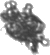

In [32]:
Image.open(img_files['imgs/32738710.jpg'])

In [33]:
nativeDF = pd.read_csv(base + 'features_native.csv.gz')
skimagDF = pd.read_csv(base + 'features_skimage.csv.gz')
labelsDF = pd.read_csv(base + 'meta.csv')

In [34]:
#print(nativeDF.isnull().sum().sort_values(ascending=False)[:10])
#print(skimagDF.isnull().sum().sort_values(ascending=False)[:6])
native_nan_cols = ['perimareaexc', 'feretareaexc', 'cdexc', 'skeleton_area',
                   'nb1_area', 'symetrieh_area', 'symetriev_area', 'convarea_area',
                  'nb2_area', 'nb3_area', ]
skimage_nan_cols = ['moments_normalized4', 'weighted_moments_normalized0', 
                    'moments_normalized1', 'moments_normalized0',
                   'weighted_moments_normalized1', 'weighted_moments_normalized4']

In [35]:
for col_name in native_nan_cols:
    nativeDF[col_name] = nativeDF[col_name].fillna(0)

for col_name in skimage_nan_cols:
    skimagDF[col_name] = skimagDF[col_name].fillna(0)

labelsDF['level1'] = labelsDF['level1'].fillna(0)
labelsDF['level2'] = labelsDF['level2'].fillna(0)

print(nativeDF.isnull().sum().any())
print(skimagDF.isnull().sum().any())
print(labelsDF.isnull().sum().any())

False
False
False


In [36]:
print('Nr. of unique level1 names')
print(labelsDF['level1'].nunique())
print('Nr. of unique level2 names')
print(labelsDF['level2'].nunique())
print('Nr. of unique names')
print(labelsDF['unique_name'].nunique())

Nr. of unique level1 names
57
Nr. of unique level2 names
40
Nr. of unique names
103


In [37]:
number_unique_names = labelsDF.groupby('level2', as_index=True)['id'].count()
number_unique_names.sort_values(inplace=True, ascending=False)

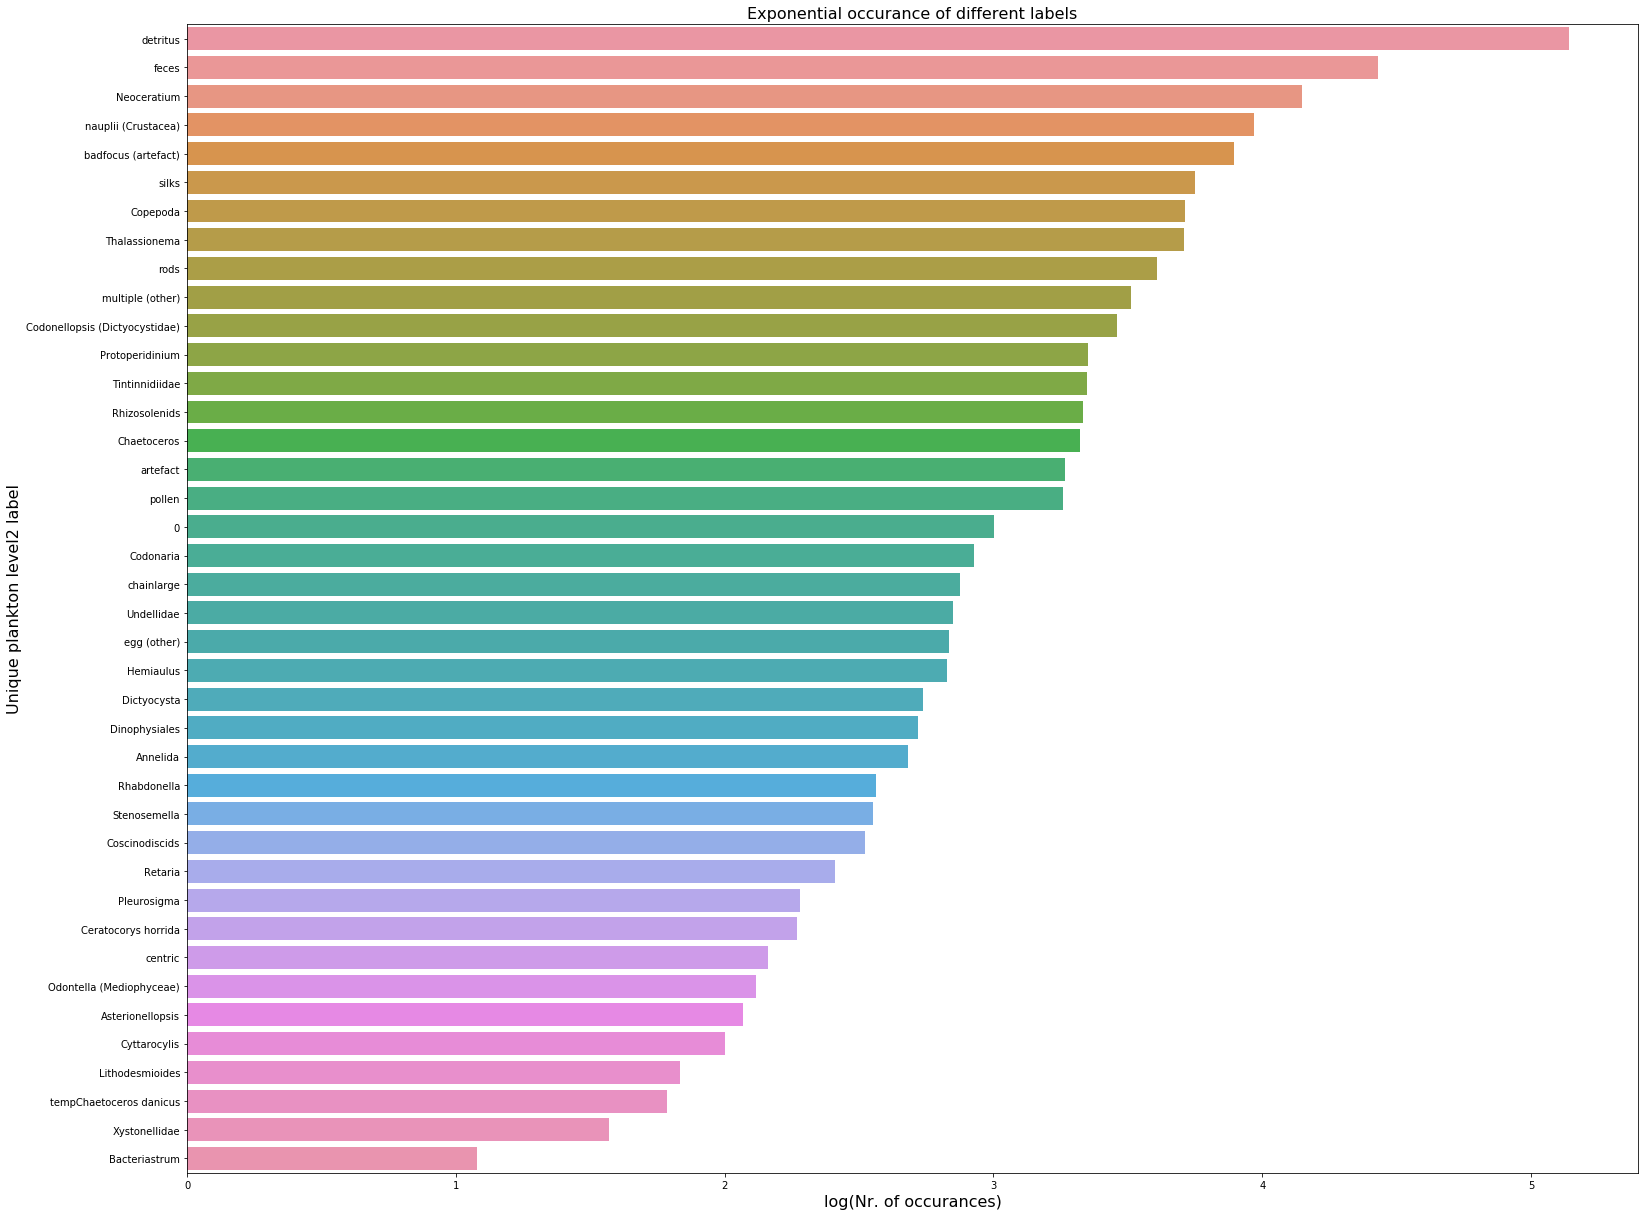

In [38]:
figure, ax = plt.subplots(figsize=(23,17))
ax = sns.barplot(y=number_unique_names.index, x=np.log10(number_unique_names.values))


plt.ylabel('Unique plankton level2 label', fontsize= 16)
plt.xlabel('log(Nr. of occurances)', fontsize= 16)
plt.title('Exponential occurance of different labels', fontsize=16)
plt.tight_layout()

In [44]:
# code inspired by https://jdhao.github.io/2017/11/06/resize-image-to-square-with-padding/

def image_processing(path):
    desired_size = 972 # max of width and height in dataset
    im_orginal = Image.open(path)
    old_size = im_orginal.size  # old_size[0] is in (width, height) format
    
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    im_scaled = im_orginal.resize(new_size) # scale up picture before padding to keep information
    
    delta_w = desired_size - new_size[0]
    delta_h = desired_size - new_size[1]
    padding = (delta_w//2, delta_h//2, delta_w-(delta_w//2), delta_h-(delta_h//2))
    im_padded = ImageOps.expand(im_scaled, padding, fill=255) # padding of scaled picture
    
    final_size = (100, 100) # input size for CNN
    im_final = im_padded.resize(final_size, resample=0) # resize to input size of CNN
    img_array = np.array(im_final)
    return(img_array)
    
test = image_processing(img_files['imgs/32582800.jpg']) # test
print(test.shape)


(100, 100)


In [56]:
# processes image before training
def autoloader(list_of_objid):
    list_of_keys = [('imgs/' + str(id) + '.jpg') for id in list_of_objid]
    return np.array([image_processing(img_files[key]) for key in list_of_keys])

In [47]:
nativeDF['objid'] = nativeDF['objid'].astype(np.int64, errors='ignore')
nativeDF[:5]

,objid,area,meanimagegrey,mean,stddev,min,perim.,width,height,major,...,symetriev_area,nb1_area,nb2_area,nb3_area,nb1_range,nb2_range,nb3_range,median_mean,median_mean_range,skeleton_area
0,32756761,6653.0,167.18,205.76,65.341,85,779.66,109,123,147.8,...,0.005988,0.017964,0.017964,0.059880,0.017647,0.017647,0.058824,47,0.276471,91.778443
1,32759364,1275.0,165.83,234.29,38.562,98,186.99,33,65,82.4,...,0.012048,0.024096,0.012048,0.006024,0.025478,0.012739,0.006369,21,0.133758,18.030120
2,32758055,2416.0,167.92,239.15,25.590,94,276.33,26,115,138.8,...,0.017857,0.011905,0.053571,0.107143,0.012422,0.055901,0.111801,16,0.099379,24.892857
3,32758988,1433.0,167.34,248.79,20.933,107,388.40,126,117,151.2,...,0.005988,0.000000,0.000000,0.023952,0.000000,0.000000,0.027027,6,0.040541,99.365269
4,32760598,1650.0,166.89,250.42,14.603,124,751.96,66,239,278.7,...,0.017964,0.029940,0.083832,0.059880,0.038168,0.106870,0.076336,5,0.038168,109.449102


In [59]:
list_objid = list(nativeDF['objid'][:5])
imgs = autoloader(list_objid)
print(imgs.shape)

(5, 100, 100)
